In [2]:
library(tidyverse)
library(reshape2)
library(gridExtra)
setwd("~/hbv_covar3/analysis/sim_seq/")

# result files
pattern = "simresult.*txt"
result_files <- list.files("./", pattern = pattern)

if (length(result_files) == 0) {
  stop("No result files found")
}


Warning message:
"package 'dplyr' was built under R version 4.3.2"
Warning message:
"package 'stringr' was built under R version 4.3.2"
-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v lubridate 1.9.3     v tibble    3.2.1
v purrr     1.0.2     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [3]:
# get the running parameter for each result
files_strat <- map_chr(strsplit(result_files, "_"), 2)
files_strat <- strsplit(files_strat, '[lnfu]')
strat_tb <- do.call(rbind, files_strat)[, -1]
strat_tb <- as.data.frame(apply(strat_tb, 2, as.numeric))
colnames(strat_tb) <- c("l", "n", "f", "u")
l_unique <- unique(strat_tb$l)
n_unique <- unique(strat_tb$n)
f_unique <- unique(strat_tb$f)
u_unique <- unique(strat_tb$u)
# get the result for each parameter combination

coev_pair <- c("site1:site2", "site2:site3") # the true coevolving pairs
indir_coev_pair <- c("site1:site3") # the indirect coevolution

result <- list()
lnf_comb <- expand.grid(l_unique, n_unique, f_unique, u_unique)
for (i in 1:nrow(lnf_comb)) {
    l <- lnf_comb[i, 1]
    n <- lnf_comb[i, 2]
    f <- lnf_comb[i, 3]
    u <- lnf_comb[i, 4]
    param_set <- paste0("l", l, "n", n, "f", f, "u", u)
    result[[param_set]] <- list()
    cur_strat_ind <- which(
                strat_tb$l == l &
                strat_tb$n == n &
                strat_tb$f == f &
                strat_tb$u == u
            )
    cur_files <- result_files[cur_strat_ind]

    # read each result files to get the simulation result
    for (file in cur_files) {
        # if there is no line, then there is no TP nor FP
        if (file.info(file)$size < 2) {
            tp_cnt <- 0
            fp1_cnt <- 0
            fp2_cnt <- 0
        } else {
            # get the pair id from the result files
            cur_result <- read.table(file, sep = " ", header = F)
            colnames(cur_result) <- c("siteA", "siteB")
            cur_result$pair_id <- map_chr(1:nrow(cur_result), function(x) {
                paste(sort(c(cur_result[x, 1], cur_result[x, 2])), collapse = ":")
            })
            pair_id_unique <- unique(cur_result$pair_id)
            # we are not interested in edge_length signal
            el_ind <- grep("edge_length", pair_id_unique)
            if (length(el_ind) > 0) {
                pair_id_unique <- pair_id_unique[-el_ind]
            }
            
            # use the pair_id to find the TP and FP
            tp_cnt <- sum(pair_id_unique %in% coev_pair)
            fp1_cnt <- sum(pair_id_unique %in% indir_coev_pair)
            fp2_cnt <- length(pair_id_unique) - tp_cnt - fp1_cnt
        }
        result[[param_set]][[file]] <- c(tp_cnt, fp1_cnt, fp2_cnt)
       
    }
}

# group each parameter set in to a table
result_tb <- map(result, function(x) {
    cur_result <- as.data.frame(do.call(rbind, x))
    colnames(cur_result) <- c("coev_found", "indir_coev_found", "false_coev_found")
    return(cur_result)
})

In [4]:
# From the result, get the performance of each parameter set
true_dir_assoc_cnt <- 2
true_indir_assoc_cnt <- 1

roc_result <- list()
lnf_comb <- expand.grid(l_unique, n_unique, f_unique, u_unique)
for (i in 1:nrow(lnf_comb)) {    
    l <- lnf_comb[i, 1]
    n <- lnf_comb[i, 2]
    f <- lnf_comb[i, 3]
    u <- lnf_comb[i, 4]
    param_set <- paste0("l", l, "n", n, "f", f, "u", u)

    true_no_assoc_cnt <- choose(l, 2)
    cur_result <- result_tb[[param_set]]
    avg_tpr <- sum(cur_result$coev_found)/(true_dir_assoc_cnt*nrow(cur_result))
    avg_fpr <- (sum(cur_result$indir_coev_found) + sum(cur_result$false_coev_found))/(true_no_assoc_cnt * nrow(cur_result))
    avg_indir <- sum(cur_result$indir_coev_found) / nrow(cur_result)
    roc_result[[param_set]] <- c(avg_tpr, avg_fpr, avg_indir)
}

roc_result <- do.call(rbind, roc_result)
colnames(roc_result) <- c("avg_tpr", "avg_fpr", "avg_indir")

In [5]:
head(roc_result)

,avg_tpr,avg_fpr,avg_indir
l100n1000f100u0.01,0.000000000,0.0006970807,0
l100n100f100u0.01,0.000000000,0.0003708316,0
l100n2000f100u0.01,0.005434783,0.0004216074,0
l100n1000f10u0.01,0.005376344,0.0007733246,0
l100n100f10u0.01,0.000000000,0.0003320562,0
l100n2000f10u0.01,0.005376344,0.0008623873,0


## Contour plots

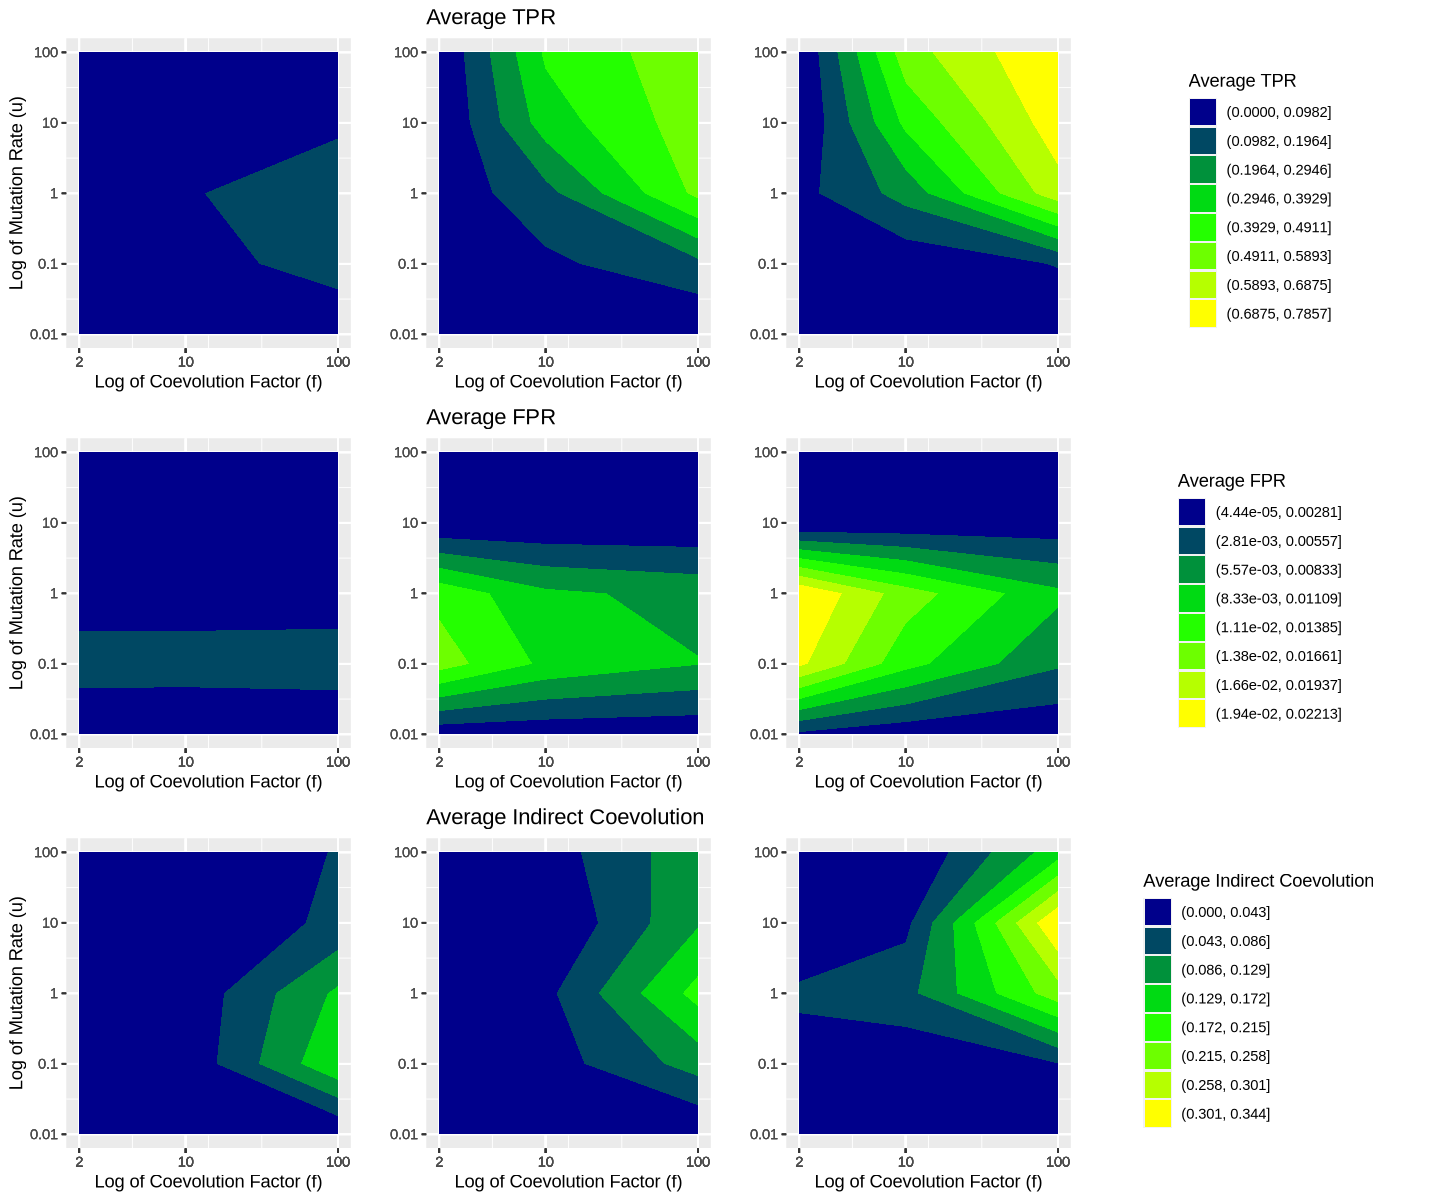

In [28]:
# Load necessary libraries
library(ggplot2)
library(reshape2)

# Load the data
# Replace 'path_to_your_data.csv' with the actual path to your data file
data <- as.data.frame(roc_result)

# Data preparation
data$sequence_length <- as.numeric(sub(".*l([0-9]+).*", "\\1", rownames(data)))
data$sample_size <- as.numeric(sub(".*n([0-9]+).*", "\\1", rownames(data)))
data$coev_factor <- as.numeric(sub(".*f([0-9.]+).*", "\\1", rownames(data)))
data$mutation_rate <- as.numeric(sub(".*u([0-9.]+).*", "\\1", rownames(data)))

# set global min and max for avg_tpr, avg_fpr, avg_indir
global_avg_tpr_range <- c(min(data$avg_tpr), max(data$avg_tpr))
global_avg_fpr_range <- c(min(data$avg_fpr), max(data$avg_fpr))
global_avg_indir_range <- c(min(data$avg_indir), max(data$avg_indir))

# set break points for the color scale
mybreaks_tpr <- seq(global_avg_tpr_range[1], global_avg_tpr_range[2], length.out = 9)
mybreaks_fpr <- seq(global_avg_fpr_range[1], global_avg_fpr_range[2], length.out = 9)
mybreaks_indir <- seq(global_avg_indir_range[1], global_avg_indir_range[2], length.out = 9)

#Function to return the desired number of colors
mycolors <- function(x) {
   colors <- colorRampPalette(c("darkblue", "green", "yellow"))(8)
   colors[1:x]
}

#Function to create labels for legend
breaklabel <- function(mybreaks){
   labels <- paste0(mybreaks[1:8], "-", mybreaks[2:9])
   labels
}

#Function to create the contour plot
create_contour_plot <- function(data, z, mybreaks, mycolors, title, position) {
   p <- ggplot(data, aes(x=log10(coev_factor), y=log10(mutation_rate), z=z)) +
      geom_contour_filled(breaks = mybreaks) +
      scale_fill_manual(name = title, values = mycolors(10), drop=FALSE) +
      scale_x_continuous(name="Log of Coevolution Factor (f)", 
                         breaks=log10(data$coev_factor), 
                         labels=data$coev_factor) +
      scale_y_continuous(name="Log of Mutation Rate (u)", 
                         breaks=log10(data$mutation_rate), 
                         labels=data$mutation_rate) +
      theme(legend.position = "none") +
      ggtitle(title)
   # if position is not left, then set the text to ""
   if (position != "left") {
      p <- p + theme(axis.title.y = element_text(color = "transparent"))
   }
   # if position is not middle, then hide the plot title (by setting it to empty string)
   if (position != "middle") {
      p <- p + theme(plot.title = element_text(color = "transparent"))
   }
   # if position is not right then hide the legend
   if (position == "legend") {
      p <- p + theme(legend.position = "right")
      p_legend <- ggplot_gtable(ggplot_build(p))
      legend <- p_legend$grobs[[which(p_legend$layout$name == "guide-box")]]
      return(legend)
   }
   return(p)
}


plots_tpr <- list()
plots_fpr <- list()
plots_indir <- list()

# Loop through each sample size and generate a contour plot for avg_tpr, avg_fpr, avg_indir
unique_sample_sizes <- sort(unique(data$sample_size))
for (samp_size in unique_sample_sizes) {
  subset_data <- subset(data, sample_size == samp_size)
   # get the position of the plot
   position <- ""
   if (samp_size == unique_sample_sizes[1]) {
      position <- "left"
   } else if (samp_size == unique_sample_sizes[length(unique_sample_sizes)]) {
      position <- "right"
   } else if (samp_size == unique_sample_sizes[ceiling(length(unique_sample_sizes)/2)]) {
      position <- "middle"
   }
  # Creating contour plots
   p_tpr <- create_contour_plot(subset_data, subset_data$avg_tpr, mybreaks_tpr, mycolors, "Average TPR", position)
   grob_tpr <- ggplotGrob(p_tpr)
   plots_tpr[[length(plots_tpr) + 1]] <- grob_tpr

   p_fpr <- create_contour_plot(subset_data, subset_data$avg_fpr, mybreaks_fpr, mycolors, "Average FPR", position)
   grob_fpr <- ggplotGrob(p_fpr)
   plots_fpr[[length(plots_fpr) + 1]] <- grob_fpr

   p_indir <- create_contour_plot(subset_data, subset_data$avg_indir, mybreaks_indir, mycolors, "Average Indirect Coevolution", position)
   grob_indir <- ggplotGrob(p_indir)
   plots_indir[[length(plots_indir) + 1]] <- grob_indir
}

# Adding legend to each row
p_legend_tpr <- create_contour_plot(subset_data, subset_data$avg_tpr, mybreaks_tpr, mycolors, "Average TPR", "legend")
p_legend_fpr <- create_contour_plot(subset_data, subset_data$avg_fpr, mybreaks_fpr, mycolors, "Average FPR", "legend")
p_legend_indir <- create_contour_plot(subset_data, subset_data$avg_indir, mybreaks_indir, mycolors, "Average Indirect Coevolution", "legend")
plots_tpr[[length(plots_tpr) + 1]] <- p_legend_tpr
plots_fpr[[length(plots_fpr) + 1]] <- p_legend_fpr
plots_indir[[length(plots_indir) + 1]] <- p_legend_indir

# plot results
options(repr.plot.width = 12, repr.plot.height = 10)
grid.arrange(grobs = c(plots_tpr, plots_fpr, plots_indir), ncol = length(unique_sample_sizes) + 1)





In [34]:
library(ggplot2)
library(gridExtra)
library(grid)

# ... [previous code remains the same until the plotting part] ...

# Function to modify individual plots
modify_plot <- function(plot, display_x_axis=FALSE, display_y_axis=FALSE, display_legend=FALSE) {
  # Initialize an empty list to store theme modifications
  theme_modifications <- list()

  # Conditionally add axis title modifications
  if (!display_x_axis) {
    theme_modifications[[length(theme_modifications) + 1]] <- theme(axis.title.x = element_blank())
  }
  if (!display_y_axis) {
    theme_modifications[[length(theme_modifications) + 1]] <- theme(axis.title.y = element_blank())
  }

  # Add legend position modification
  legend_position <- ifelse(display_legend, "right", "none")
  theme_modifications[[length(theme_modifications) + 1]] <- theme(legend.position = legend_position)

  # Apply all theme modifications to the plot
  for (mod in theme_modifications) {
    plot <- plot + mod
  }

  plot
}

# Modify and store plots
for (i in seq_along(unique_sample_sizes)) {
  samp_size <- unique_sample_sizes[i]

  subset_data <- subset(data, sample_size == samp_size)

  # Modify plots based on position
  plots_tpr[[i]] <- modify_plot(plots_tpr[[i]], display_y_axis = (i == 1))
  plots_fpr[[i]] <- modify_plot(plots_fpr[[i]], display_x_axis = (i == round(length(unique_sample_sizes) / 2)))
  plots_indir[[i]] <- modify_plot(plots_indir[[i]], display_legend = (i == length(unique_sample_sizes)))
}

# Create a list to hold the arranged rows
arranged_rows <- list()

# Arrange each row with its title
for (i in 1:length(unique_sample_sizes)) {
  row_title <- textGrob(paste("Sample Size:", unique_sample_sizes[i]), gp = gpar(fontface = "bold", fontsize = 14), vjust = 1)
  arranged_row <- arrangeGrob(row_title, arrangeGrob(plots_tpr[[i]], plots_fpr[[i]], plots_indir[[i]], ncol = 3), ncol = 1)
  arranged_rows[[i]] <- arranged_row
}

# Combine all rows
final_plot <- do.call(grid.arrange, c(arranged_rows, ncol = 1))

# Print the final plot
print(final_plot)


ERROR: [1m[33mError[39m in `plot_theme()`:[22m
[1m[22m[33m![39m Problem merging the `axis.title.y` theme element
[1mCaused by error in `merge_element()`:[22m
[1m[22m[33m![39m No method for merging [34m<list>[39m into [34m<element_text>[39m


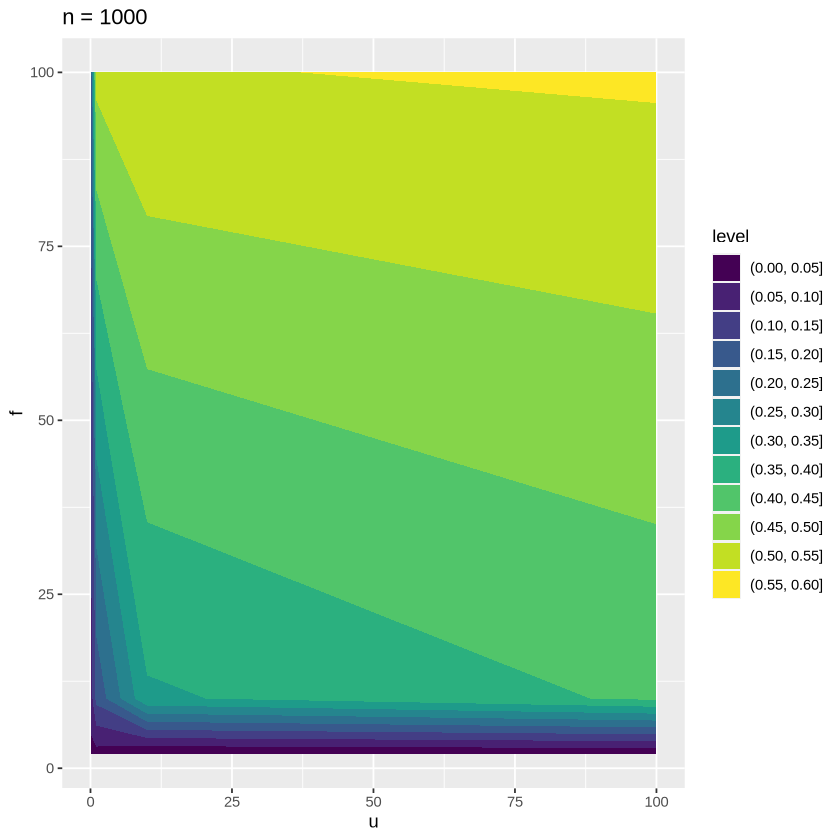

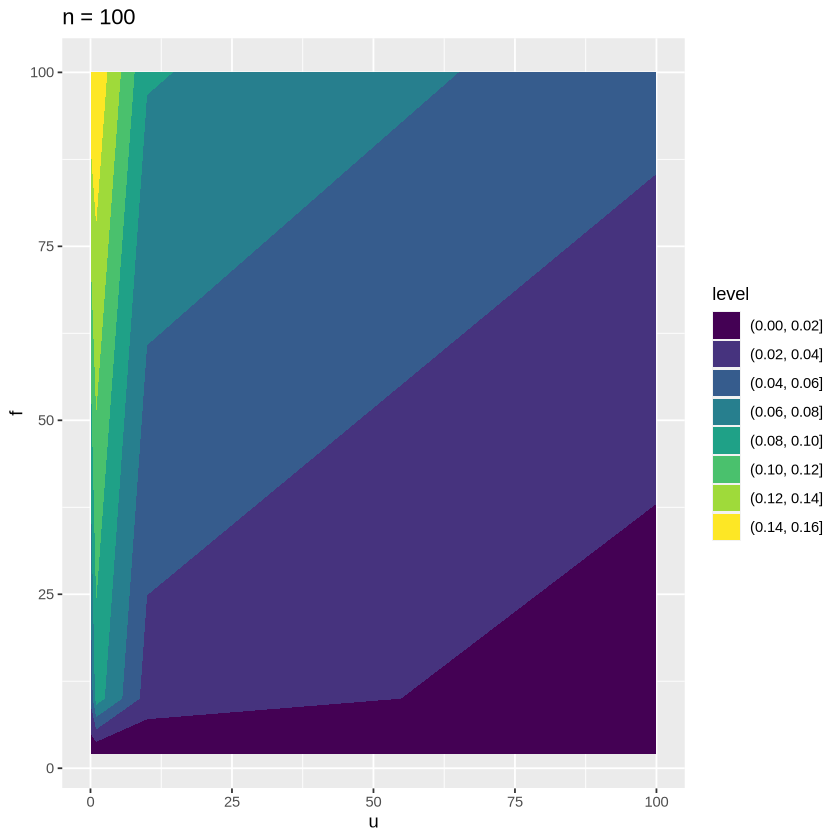

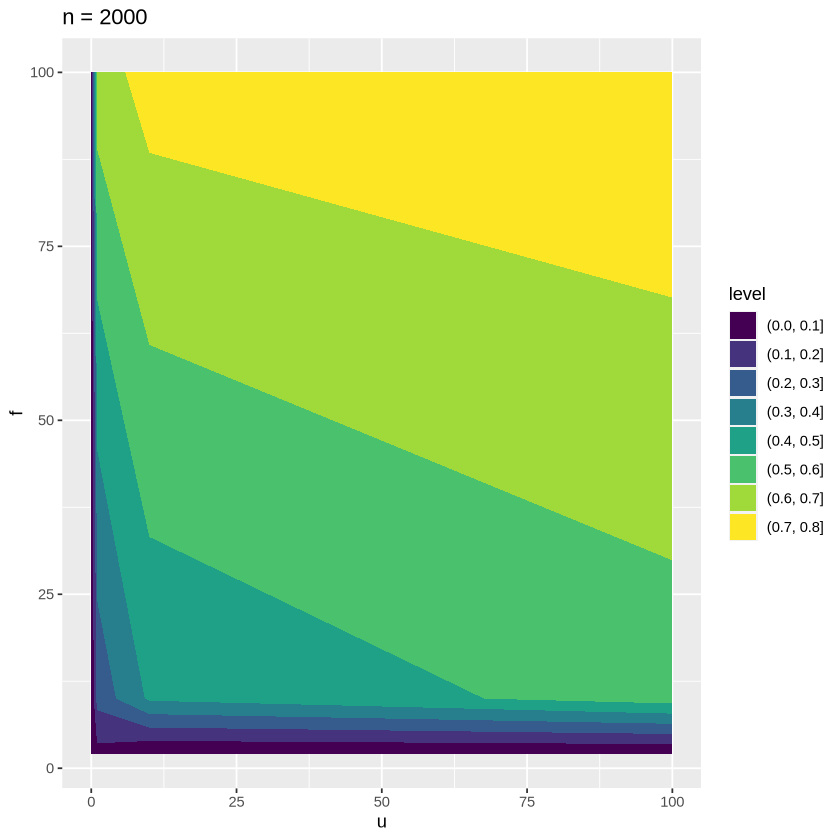

In [78]:
library(ggplot2)
for (n in n_unique) {
    grid <- expand.grid(u = u_unique, f = f_unique)
    grid$param_set <- paste0("l", l, "n", n, "f", grid$f, "u", grid$u)
    grid$avg_tpr <- roc_result[grid$param_set, "avg_tpr"]
    print(ggplot(grid, aes(u, f, z=avg_tpr)) + 
        geom_contour_filled() +
        ggtitle(paste0("n = ", n)))
}


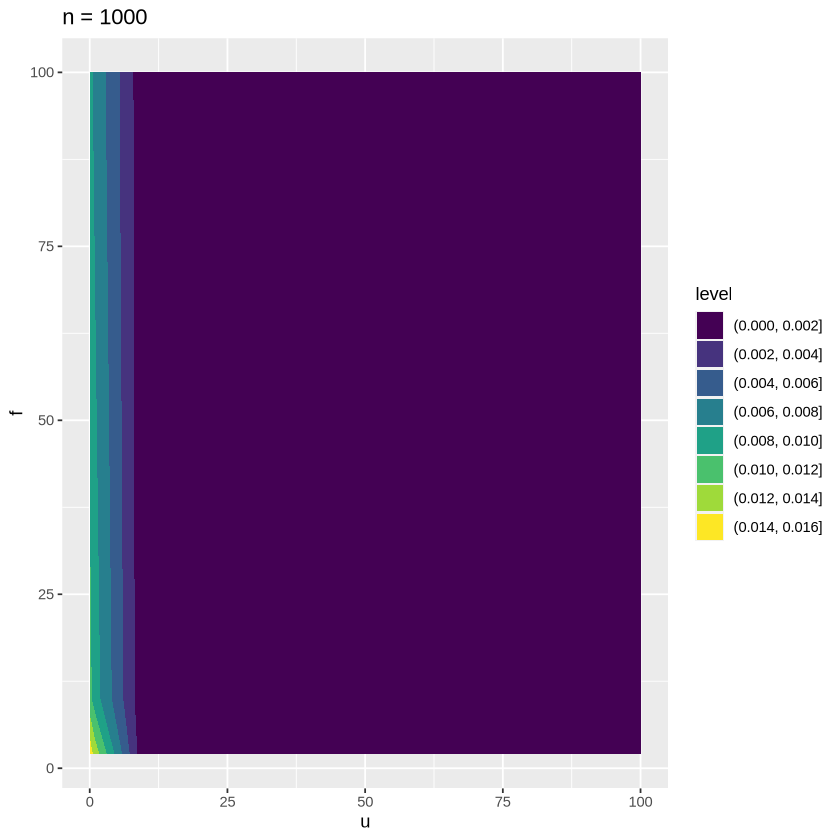

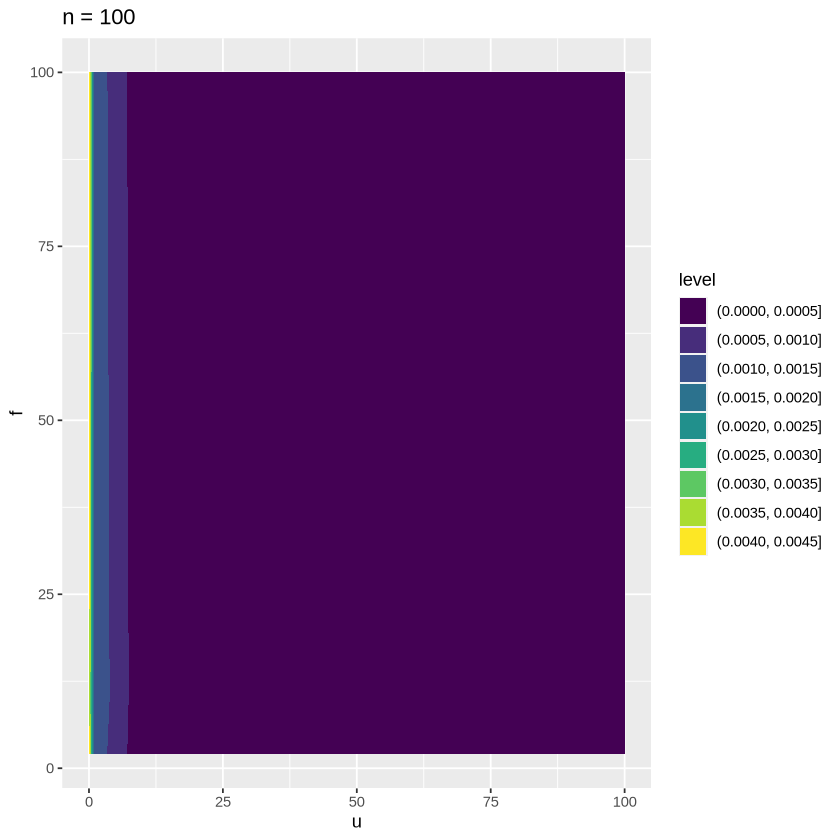

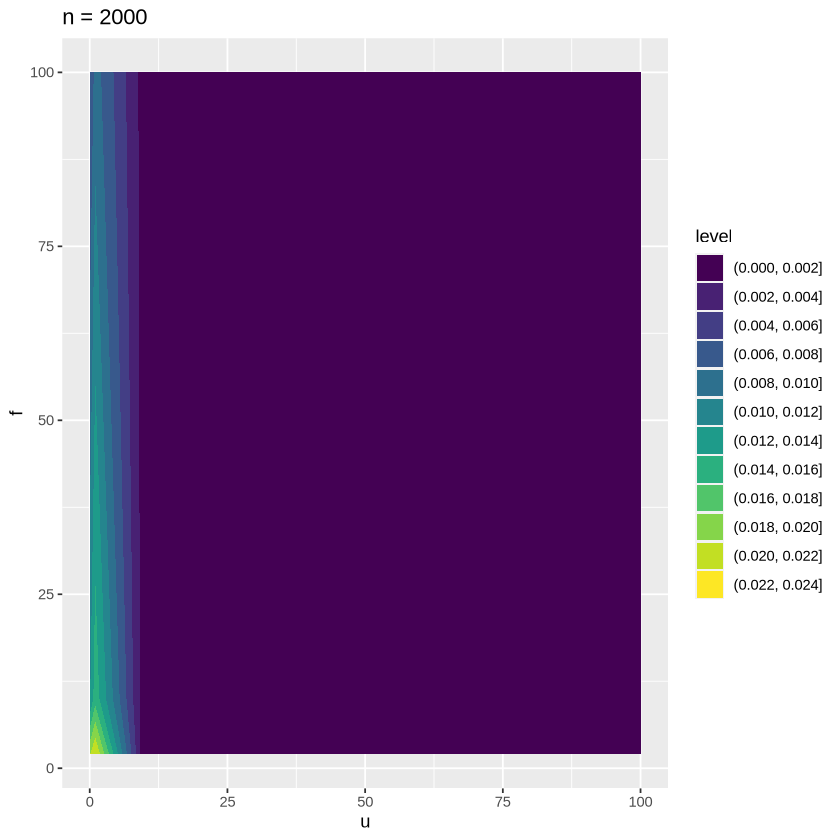

In [80]:
library(ggplot2)
for (n in n_unique) {
    grid <- expand.grid(u = u_unique, f = f_unique)
    grid$param_set <- paste0("l", l, "n", n, "f", grid$f, "u", grid$u)
    grid$avg_tpr <- roc_result[grid$param_set, "avg_fpr"]
    print(ggplot(grid, aes(u, f, z=avg_tpr)) + 
        geom_contour_filled() +
        ggtitle(paste0("n = ", n)))
}


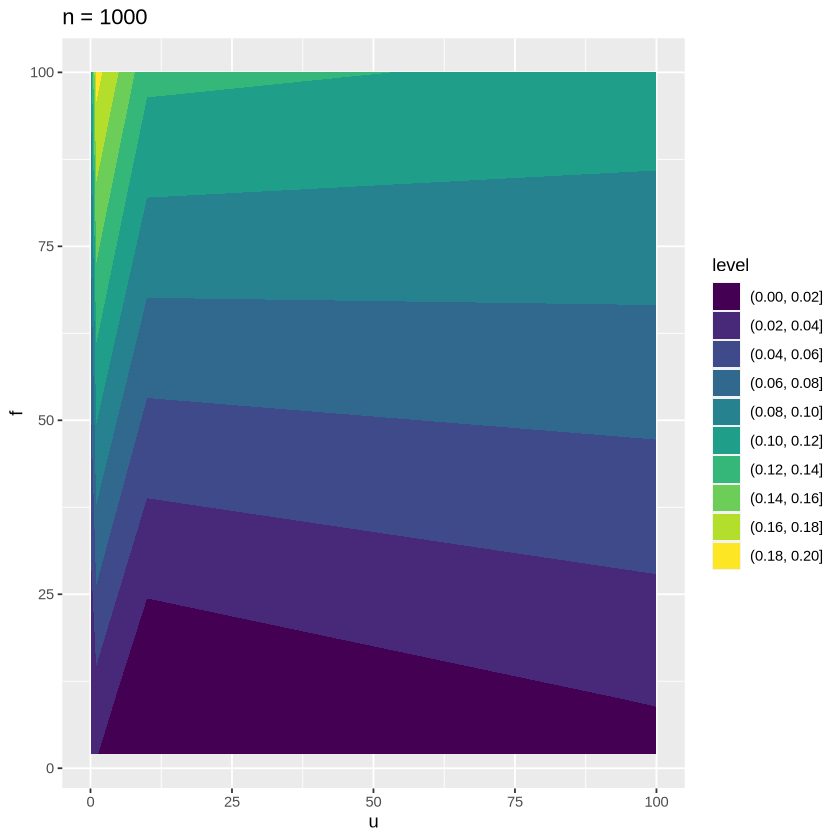

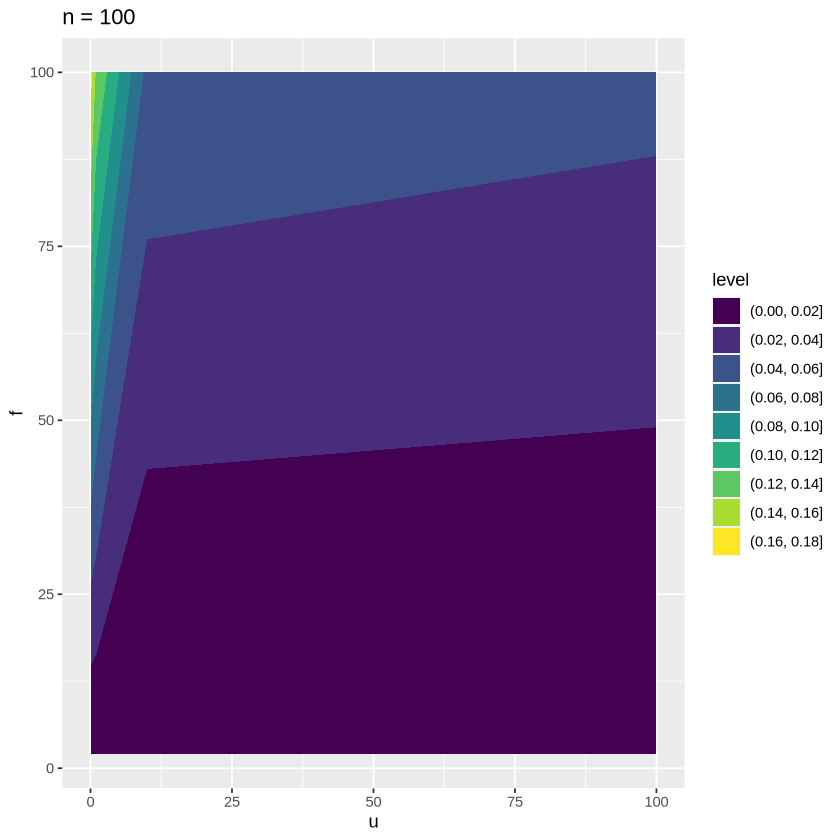

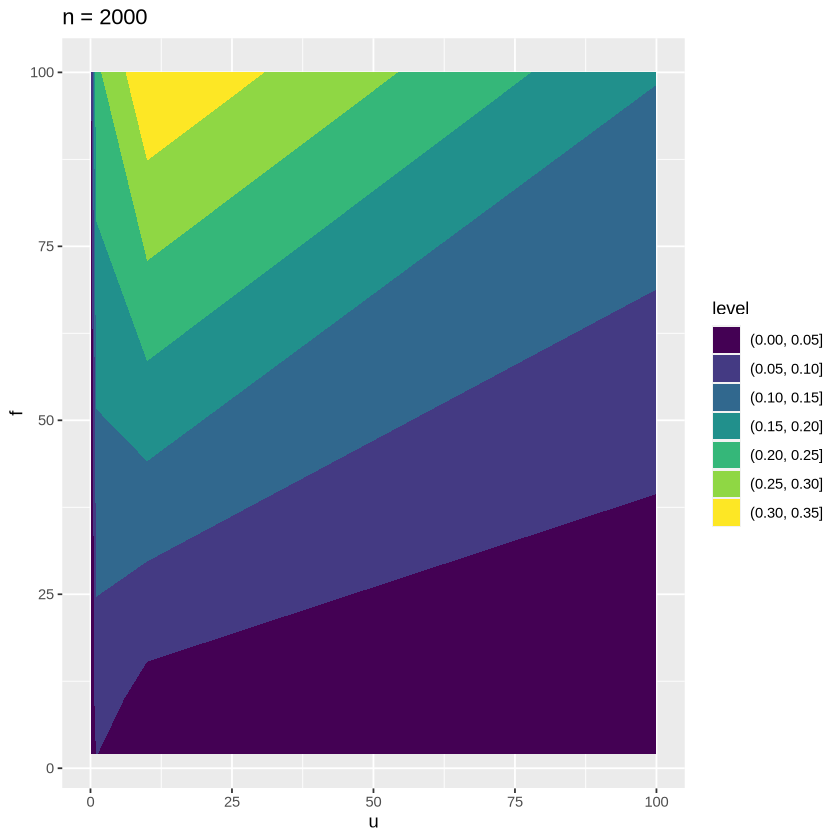

In [81]:
library(ggplot2)
for (n in n_unique) {
    grid <- expand.grid(u = u_unique, f = f_unique)
    grid$param_set <- paste0("l", l, "n", n, "f", grid$f, "u", grid$u)
    grid$avg_tpr <- roc_result[grid$param_set, "avg_indir"]
    print(ggplot(grid, aes(u, f, z=avg_tpr)) + 
        geom_contour_filled() +
        ggtitle(paste0("n = ", n)))
}


In [62]:
detach(package:ggplot2, unload=TRUE)
library(ggplot2)

In [86]:
u_unique

[1] 1e-02 1e-01 1e+02 1e+01 1e+00

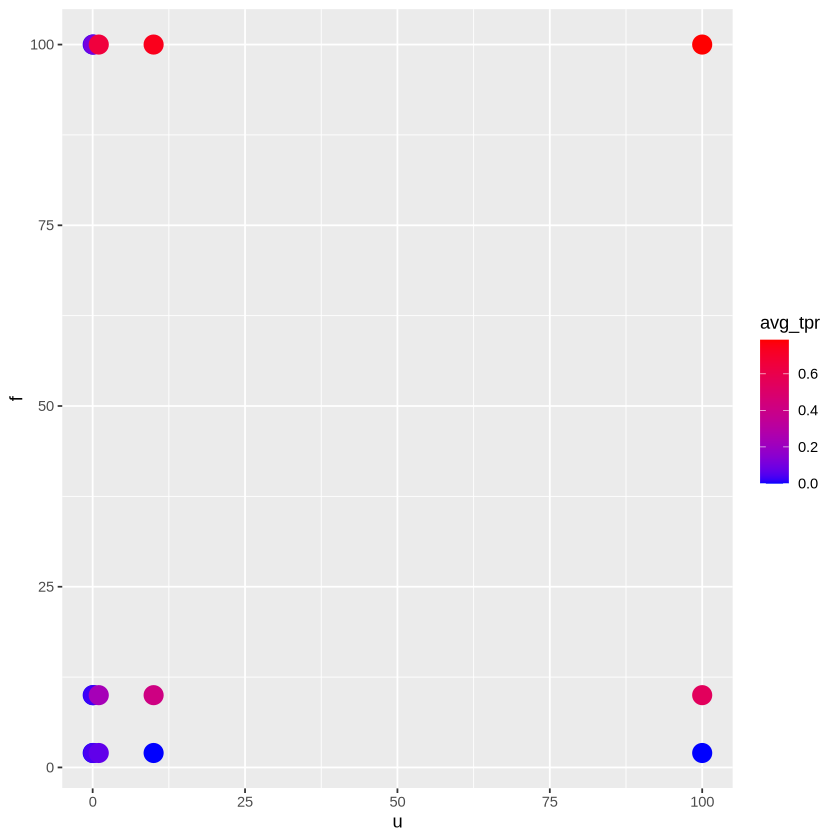

In [85]:
# plot dot plot, with the color indicating the avg_tpr
grid <- expand.grid(u = u_unique, f = f_unique)
grid$param_set <- paste0("l", l, "n", n, "f", grid$f, "u", grid$u)
grid$avg_tpr <- roc_result[grid$param_set, "avg_tpr"]
grid$avg_fpr <- roc_result[grid$param_set, "avg_fpr"]
grid$avg_indir <- roc_result[grid$param_set, "avg_indir"]
ggplot(grid, aes(u, f, color=avg_tpr)) + 
    geom_point() + 
    scale_color_gradient(low="blue", high="red") +
    # increase the size of the points
    geom_point(size=5)

In [ ]:
library(ggplot2)

# Creating sample data
x <- seq(-10, 10, length.out = 100)
y <- seq(-10, 10, length.out = 100)
grid <- expand.grid(X=x, Y=y)
grid$Z <- with(grid, sin(sqrt(X^2 + Y^2)))

# Plotting with ggplot2
ggplot(grid, aes(X, Y, z = Z)) +
  geom_contour()
